# Generate Attribution Graphs

## Import packages

In [34]:
import json
import operator
import numpy as np
import networkx as nx
from time import time
import lucid.modelzoo.vision_models as models
import matplotlib.pyplot as plt

## Functions to get general information of inception_v1 model

In [2]:
def get_layers(graph_nodes):
    '''
    Get all layers
    * input
        - graph_nodes: tensorflow graph nodes
    * output
        - layers: list of all layers
    '''
    layers = []
    for n in graph_nodes:
        node_name = n.name
        if node_name[-2:] == '_w':
            layer = node_name.split('_')[0]
            if layer not in layers:
                layers.append(layer)
    return layers

In [3]:
def get_channel_sizes(layer, weight_nodes):
    '''
    Get channel sizes
    * input
        - layer: the name of layer
        - weight_nodes: tensorflow nodes for all filters
    * output
        - channel_sizes: list of channel size for all pre-concatenated blocks
    '''
    
    channel_sizes = [get_shape_of_node(n)[0] for n in weight_nodes if layer in n.name and '_b' == n.name[-2:] and 'bottleneck' not in n.name]
    return channel_sizes

In [4]:
def get_shape_of_node(n):
    '''
    Get the shape of the tensorflow node
    * input
        - n: tensorflow node
    * output
        - tensor_shape: shape of n
    '''
    dims = n.attr['value'].tensor.tensor_shape.dim
    tensor_shape = [d.size for d in dims]
    return tensor_shape

In [5]:
def get_prev_layer(layer, mixed_layers):
    layer_idx = mixed_layers.index(layer)
    return mixed_layers[layer_idx - 1]

## Functions to extract influences from I-matrices for a class

In [6]:
def extract_class_I_matrices(Is, all_layers, start_layer, end_layer, pred_class, verbose=True):
    '''
    Extract influences for a class from I-matrices
    * input
        - Is: I-matrices for all class
        - all_layers: list of all layers
        - start_layer: start layer (towards output)
        - end_layer: end layer (towards input)
        - pred_class: predicted class
    * output
        - Is_class: I-matrices for a class. a dictionary, where
            - key: layer name (e.g. 'mixed4d', 'mixed4d_1')
            - val: influences for given layer(key), class(argument of the function)
    '''

    # Get layers starting from the given layer to the input layer
    start_idx, end_idx = all_layers.index(start_layer), all_layers.index(end_layer)
    target_layers = all_layers[start_idx: end_idx - 1: -1]
    
    Is_class = {}
    
    for layer in target_layers:
        if verbose:
            print('\n({}) loading {}'.format(pred_class, layer), end='')
        Is_class[layer] = Is[layer][pred_class]
        for branch in [1, 2]:
            inner_layer = '{}_{}'.format(layer, branch)
            if verbose:
                print(',', inner_layer, end='')
            Is_class[inner_layer] = Is[inner_layer][pred_class]
    if verbose:
        print('\n')
    
    return Is_class

In [7]:
def load_I_matrices(all_layers, start_layer, end_layer, I_mat_dirpath, verbose=True):
    '''
    Load I-matrices for all layers
    * input
        - all_layers: list of all layers
        - start_layer: start layer (towards output)
        - end_layer: end layer (towards input)
        - I_mat_dirpath: directory path of I-matrices
    * output
        - Is: I-matrices for all class
    '''
    
    # Get layers starting from the given layer to the input layer
    start_idx, end_idx = all_layers.index(start_layer), all_layers.index(end_layer)
    target_layers = all_layers[start_idx: end_idx - 1: -1]

    # Load I matrices
    Is = {}
    for layer in target_layers:
        if verbose:
            print('\n(all) loading {}'.format(layer), end='')
        Is[layer] = load_inf_matrix(I_mat_dirpath, layer)
        for branch in [1, 2]:
            inner_layer = '{}_{}'.format(layer, branch)
            if verbose:
                print(',', inner_layer, end='')
            Is[inner_layer] = load_inf_matrix(I_mat_dirpath, inner_layer)
    if verbose:
        print('\n')    
    return Is

In [8]:
def load_inf_matrix(I_mat_dirpath, layer):
    '''
    Load I matrix for a layer
    * input
        - mat_dirpath: directory path of I-matrices
        - layer: layer name
    * output
        - I_mat: I-matrix of the given layer
    '''
    if I_mat_dirpath[-1] == '/':
        filepath = I_mat_dirpath + 'I_' + layer + '.json'
    else:
        filepath = I_mat_dirpath + '/I_' + layer + '.json'
        
    with open(filepath) as f:
        I_mat = json.load(f)
    
    return I_mat

## Functions to extract M-matrices information

In [9]:
def read_M(M_mat_dirpath, layer):
    M = np.loadtxt(M_mat_dirpath + 'M-' + layer + '.csv', delimiter=',', dtype=int)
    return M

In [10]:
def read_Ms(M_mat_dirpath, mixed_layers):
    Ms = {}
    for layer in mixed_layers:
        M = read_M(M_mat_dirpath, layer)
        Ms[layer] = M
    return Ms

## Functions to query the influence values

In [11]:
def get_branch(layer, channel, layer_channels):
    '''
    Get branch of the channel in the layer
    * input
        - layer: the name of layer
        - channel: channel in the layer
        - layer_channels: fragment sizes of the layer
    * output
        - branch: branch of the channel
    '''
    
    channels = layer_channels[:]
    for i in range(len(channels) - 1):
        channels[i + 1] += channels[i]
        
    branch = np.searchsorted(channels, channel, side='right')
    
    return branch

In [12]:
def avg_num_of_prevs_for_a_channel(layer, Is_class):
    '''
    Get the average number of previous channels connected to a channel in the given layer
    * input
        - layer: layer
        - Is_class: I-matrices for a class
    * output
        - num_avg: the average number of connections for a channel in the given layer
    '''
    
    num_of_channel_edges = []
    
    for channel, prev_inf_dict in enumerate(Is_class[layer]):
        # Get branch
        branch = get_branch(layer, channel, layer_fragment_sizes[layer])
        
        if branch in [0, 3]:
            num_of_channel_edges.append(len(prev_inf_dict))
            
    num_avg = int(np.average(num_of_channel_edges))
    
    return num_avg

## Functions to generate the graph

In [13]:
def get_node_name(layer, channel):
    return layer + '-' + str(channel)

In [14]:
def gen_full_graph(Is_class, G, mixed_layers):
    
    # Add edges into G from Is_class
    for layer_idx, layer in enumerate(mixed_layers[::-1][:-1]):
        # Get previous layer
        prev_layer = mixed_layers[::-1][layer_idx + 1]
        
        # Get the average number of edges for a channel
        avg_num_edges = avg_num_of_prevs_for_a_channel(layer, Is_class)
        
        # For all channels in layer
        for channel, prev_inf_dict in enumerate(Is_class[layer]):
            # Get source node
            src = get_node_name(layer, channel)
            
            # Get branch
            branch = get_branch(layer, channel, layer_fragment_sizes[layer])
            
            # If the channel is connected to a branch
            if branch in [1, 2]:
                # Get possible edge weights for the channel
                channel_edges = {}
                for prev_channel in prev_inf_dict:
                    prev_inf = prev_inf_dict[prev_channel]
                    
                    # Extract influence information for prev_channel
                    branch_layer = '{}_{}'.format(layer, branch)
                    prev_prev_inf_dict = Is_class[branch_layer][int(prev_channel)]
                    
                    for prev_prev_channel in prev_prev_inf_dict:
                        prev_prev_inf = prev_prev_inf_dict[prev_prev_channel]
                        if prev_prev_channel not in channel_edges:
                            channel_edges[prev_prev_channel] = []
                        channel_edges[prev_prev_channel].append(min(prev_inf, prev_prev_inf))
                        
                # Get only one weight for each channel and prev_prev channel
                for prev_prev_channel in channel_edges:
                    channel_edges[prev_prev_channel] = max(channel_edges[prev_prev_channel])
                
                # Get top (avg_num_edges) prev_prev_channels based on the edge weight
                top_prev_prevs_weights = sorted(channel_edges.items(), key=operator.itemgetter(1), reverse=True)
                top_prev_prevs_weights = top_prev_prevs_weights[:avg_num_edges]
                
                # Add edges from channel and top_prev_prev_channel
                for prev_prev_channel, weight in top_prev_prevs_weights:
                    tgt = get_node_name(prev_layer, prev_prev_channel)
                    G.add_edge(src, tgt, weight=weight)
            
            # If the channel is directly connected to the previous layer
            elif branch in [0, 3]:
                for prev_channel in prev_inf_dict:
                    # Add edge of (src, tgt-prev)
                    prev_inf = prev_inf_dict[prev_channel]
                    tgt = get_node_name(prev_layer, prev_channel)
                    G.add_edge(src, tgt, weight=prev_inf)

In [15]:
def init_dag(mixed_layers):
    dag = {}
    for layer in mixed_layers[::-1]:
        dag[layer] = []
    return dag

## Functions for pagerank

In [16]:
def get_personalization_dict(G, Ms, mixed_layers, pred_class, outlier_nodes):
    '''
    Get personalization dictionary
    * input
        - G: graph
        - Ms: M matrices
        - mixed_layers: layers starting with 'mixed'
    '''
    
    personalization = {node: 1 for node in list(G.nodes)}

    for layer in mixed_layers[::-1]:
        M = Ms[layer][pred_class]
        max_m = -100
        for channel, val in enumerate(M):
            node = get_node_name(layer, channel)
            if node not in outlier_nodes:
                max_m = max(max_m, val)
                
        for channel in range(M.shape[-1]):
            node = layer + '-' + str(channel)
            if node in personalization:
                personalization[get_node_name(layer, channel)] = M[channel] / max_m
    
    return personalization

## Functions for thresholding nodes, edges

In [17]:
def get_prob_mass(prob_mass_threshold, reverse_sorted_vals):

    prob_mass = 0
    threshold_cnt = 0
    sum_val = np.sum(reverse_sorted_vals)
    
    while prob_mass < prob_mass_threshold:
        prob_mass += reverse_sorted_vals[threshold_cnt] / sum_val
        threshold_cnt += 1

    threshold_val = reverse_sorted_vals[threshold_cnt]
    return threshold_cnt, threshold_val

In [18]:
def get_threshold(mixed_layers, pagerank, prob_mass_thresholds, unified_threshold=True):
    '''
    Get threshold dictionary
    * input
        - mixed_layers: layers starting with mixed
        - pagerank: pagerank dictionary
        - prob_mass_thresholds: probability mass thresholds for each layer
        - unified_threshold: whether the same threshold is used for all layers
    * output
        - thresholds: threshold dictionary, whose 
            - key: layer
            - val: threshold criteria value
    '''
    
    thresholds = {}
    prob_mass_threshold = list(prob_mass_thresholds.values())[0]
    
    if unified_threshold:
        # Get threshold value for all layer
        threshold_val = get_threshold_val(mixed_layers, pagerank, prob_mass_threshold=prob_mass_threshold)
    
        # Get thresholds
        for layer in mixed_layers[::-1]:
            thresholds[layer] = threshold_val
    
    else:
        for layer in mixed_layers[::-1]:
            pagerank_layer = {node: pagerank[node] for node in pagerank if node.split('-')[0] == layer}
            threshold_val_layer = get_threshold_val(mixed_layers, pagerank_layer, prob_mass_threshold=prob_mass_thresholds[layer])
            thresholds[layer] = threshold_val_layer

    return thresholds

In [19]:
def get_threshold_val(mixed_layers, pagerank, prob_mass_threshold=0.12):
    pagerank_values = list(pagerank.values())
    sorted_pagerank_vals = sorted(pagerank_values, reverse=True)
    threshold_cnt, threshold_val = get_prob_mass(prob_mass_threshold, sorted_pagerank_vals)
    
    return threshold_val

In [20]:
def get_thresholded_nodes(pagerank, thresholds, outlier_nodes):
    thresholded_nodes = {}
    for node in pagerank:
        if node in outlier_nodes:
            continue
            
        layer, channel = node.split('-')
        if pagerank[node] > thresholds[layer]:
            thresholded_nodes[node] = pagerank[node]
        
    return thresholded_nodes

In [21]:
def get_thresholded_edges(mixed_layers, G, thresholded_nodes):
    '''
    Get thresholded edges
    * input
        - mixed_layers: all mixed layers
        - G: graph
        - thresholded_nodes: nodes whose pagerank value is higher than threshold
    * output
        - thresholded_edges: edges connected by both thresholded nodes
    '''
    
    # Initialize thresholded_edges
    thresholded_edges = {}
    edge_checker = set()
    for layer in mixed_layers[::-1]:
        thresholded_edges[layer] = {}

    for node in thresholded_nodes:
        for edge in G.edges(node):
            node1, node2 = edge
            if (node1 not in thresholded_nodes) or (node2 not in thresholded_nodes):
                continue

            layer, channel, prev_layer, prev_channel = parse_edge(edge, mixed_layers)
            if channel not in thresholded_edges[layer]:
                thresholded_edges[layer][channel] = []

            if (node1, node2) in edge_checker:
                continue
            elif (node2, node1) in edge_checker:
                continue
            edge_checker.add((node1, node2))

            thresholded_edges[layer][channel].append({
                'prev_channel': int(prev_channel),
                'inf': G.get_edge_data(*edge)['weight']
            })

    return thresholded_edges

In [22]:
def get_prev_nodes_with_valid_edges(thresholded_edges, thresholded_nodes, prev_layer):
    if prev_layer == 'mixed3a':
        mixed3a_nodes = [x.split('-')[1] for x in thresholded_nodes if 'mixed3a' in x]
        return mixed3a_nodes
    else:
        return list(thresholded_edges[prev_layer].keys())

## Functions to generate DAG

In [23]:
def parse_edge(edge, mixed_layers):
    n1_layer, n1_channel = edge[0].split('-')
    n2_layer, n2_channel = edge[1].split('-')
    
    n1_idx, n2_idx = mixed_layers.index(n1_layer), mixed_layers.index(n2_layer)
    
    # If n1 is current layer, n2 is previous layer
    if n1_idx > n2_idx:
        layer, channel = n1_layer, n1_channel
        prev_layer, prev_channel = n2_layer, n2_channel
        
    # If n1 is previous layer, n1 is current layer
    else:
        layer, channel = n2_layer, n2_channel
        prev_layer, prev_channel = n1_layer, n1_channel
    
    return layer, channel, prev_layer, prev_channel

In [24]:
def gen_dag(mixed_layers, thresholded_nodes, thresholded_edges, pagerank, Is, pred_class):

    # Initialize dag, check_channel, layer_validity
    dag = {}
    check_channel = {}
    layer_validity = {}
    for layer in mixed_layers[::-1]:
        dag[layer] = []
        check_channel[layer] = set()
        if layer != 'mixed3a':
            layer_validity[layer] = False
    
    # Mixed3a
    layer = 'mixed3a'
    for channel, cnt in enumerate(Ms['mixed3a'][pred_class]):
        node_name = get_node_name(layer, channel)
        if node_name in thresholded_nodes:
            dag[layer].append({
                'channel': int(channel),
                'count': int(cnt),
                'layer': layer,
                'pagerank': pagerank[node_name],
                'prev_channels': [],
                'attr_channels': []
            })
            
    # Other layers
    for node in thresholded_nodes:
        for edge in G.edges(node):
            
            # Parse the edge
            node1, node2 = edge
            layer, channel, prev_layer, prev_channel = parse_edge(edge, mixed_layers)
            
            curr_node = get_node_name(layer, channel)
            prev_node = get_node_name(prev_layer, prev_channel)
            
            # Ignore unnecessary cases
            if curr_node not in thresholded_nodes:
                continue
            if channel in check_channel[layer]:
                continue
            check_channel[layer].add(channel)
            
            # Read M matrices
            M = Ms[layer]

            # Get attributed previous channels
            attr_channels_dict = Is[layer][pred_class][int(channel)]
            attr_channels_dict = sorted(attr_channels_dict.items(), key=lambda x:x[1], reverse=True)[0:3]
            attr_channels = [{'prev_channel': prev[0], 'inf': prev[1]} for prev in attr_channels_dict]

            # If the channel is connected to thresholded nodes in previous layer
            if channel in thresholded_edges[layer]:
                # Mark the layer is valid
                layer_validity[layer] = True
            
                # Get previous channels    
                valid_prev_nodes = get_prev_nodes_with_valid_edges(thresholded_edges, thresholded_nodes, prev_layer)
                filtered_prev_channels = list(filter(lambda x: str(x['prev_channel']) in valid_prev_nodes, thresholded_edges[layer][channel]))

                # Add node into dag
                dag[layer].append({
                    'channel': int(channel),
                    'count': int(M[pred_class][int(channel)]),
                    'layer': layer,
                    'pagerank': pagerank[curr_node],
                    'prev_channels': filtered_prev_channels,
                    'attr_channels': attr_channels
                })
            
            # If the channel is not connected to thresholded nodes in previous layer
            else:
                # Add node into dag
                dag[layer].append({
                    'channel': int(channel),
                    'count': int(M[pred_class][int(channel)]),
                    'layer': layer,
                    'pagerank': pagerank[curr_node],
                    'prev_channels': [],
                    'attr_channels': attr_channels
                })

    return dag, layer_validity

## Get inception_v1 model infromation

In [25]:
# data_dirpath = '/Users/haekyu/data/summit/'
data_dirpath = '/home/fred/code/summit-notebooks/data/'
imgnet_dirpath = data_dirpath
I_mat_dirpath = data_dirpath + 'I-matrices/'
M_mat_dirpath = data_dirpath + 'M-matrices/'
dag_dirpath = data_dirpath + 'dag/'

In [26]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()
nodes = googlenet.graph_def.node

In [27]:
all_layers = get_layers(nodes)
mixed_layers = [layer for layer in all_layers if 'mixed' in layer]
layer_fragment_sizes = {layer: get_channel_sizes(layer, nodes) for layer in mixed_layers}

In [28]:
with open(imgnet_dirpath + 'imagenet.json') as f:
    imgnet = json.load(f)

## Run for all classes

In [29]:
start_layer = 'mixed5b'
end_layer = 'mixed3a'

In [30]:
Is = load_I_matrices(all_layers, start_layer, end_layer, I_mat_dirpath, verbose=True)


(all) loading mixed5b, mixed5b_1, mixed5b_2
(all) loading mixed5a, mixed5a_1, mixed5a_2
(all) loading mixed4e, mixed4e_1, mixed4e_2
(all) loading mixed4d, mixed4d_1, mixed4d_2
(all) loading mixed4c, mixed4c_1, mixed4c_2
(all) loading mixed4b, mixed4b_1, mixed4b_2
(all) loading mixed4a, mixed4a_1, mixed4a_2
(all) loading mixed3b, mixed3b_1, mixed3b_2
(all) loading mixed3a, mixed3a_1, mixed3a_2



In [31]:
outlier_nodes = ['mixed3a-67', 'mixed3a-190', 'mixed3b-390', 'mixed3b-399']

mixed3a
252


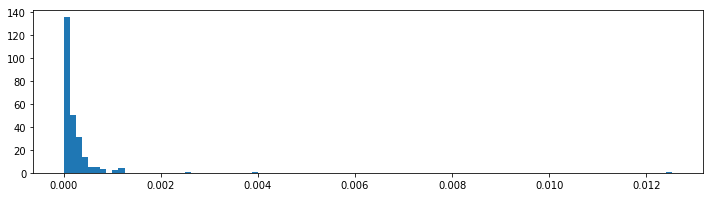

mixed3b
480


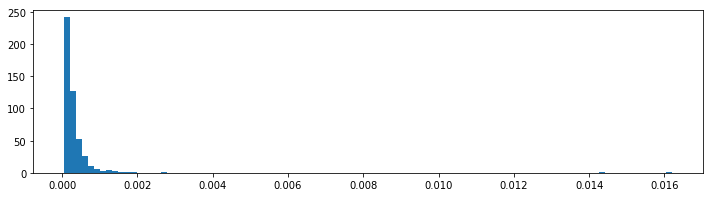

mixed4a
508


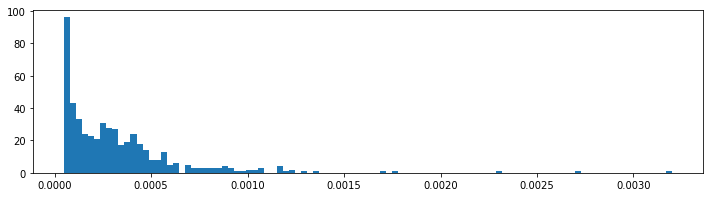

mixed4b
512


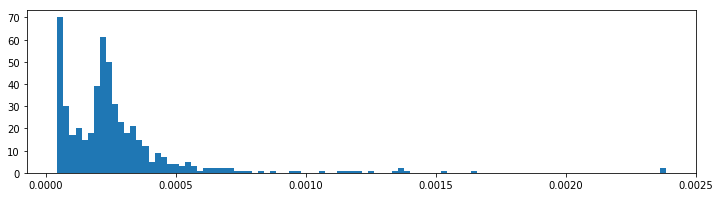

mixed4c
512


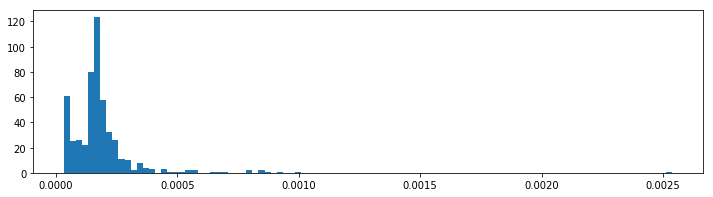

mixed4d
528


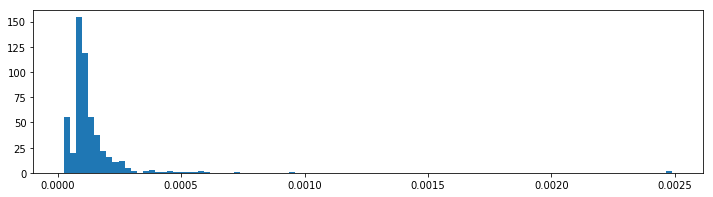

mixed4e
832


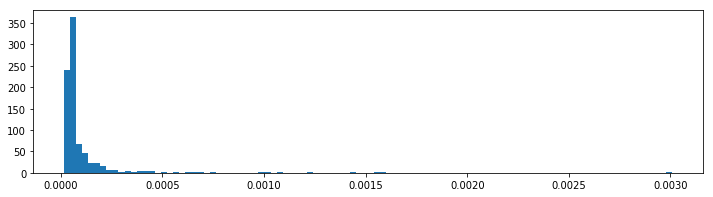

mixed5a
832


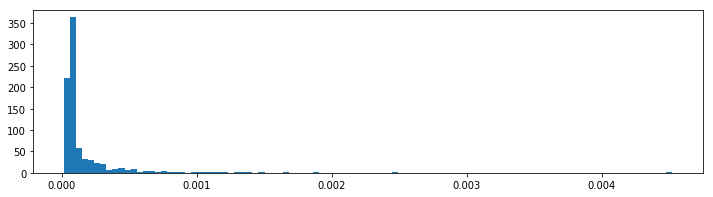

mixed5b
1024


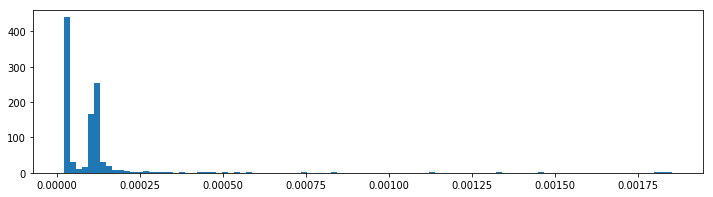

class: 55, time: 30.43 sec
mixed3a
254


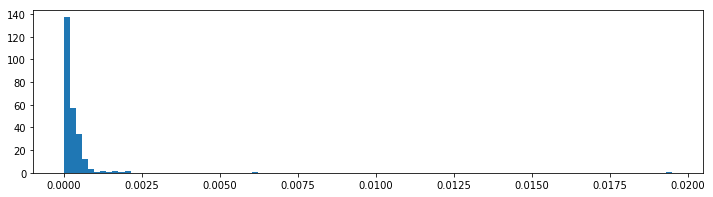

mixed3b
480


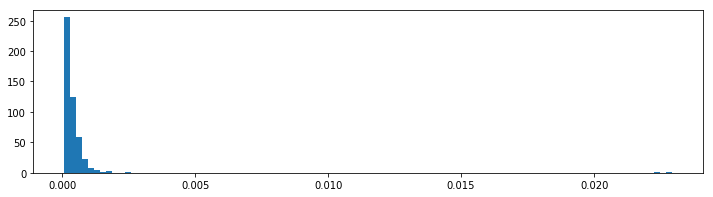

mixed4a
508


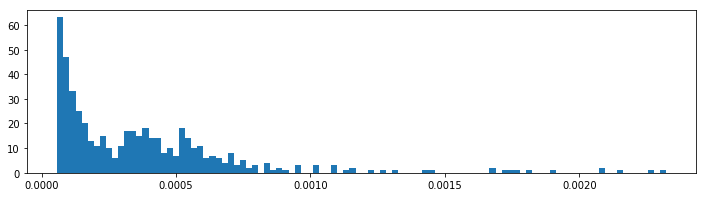

mixed4b
512


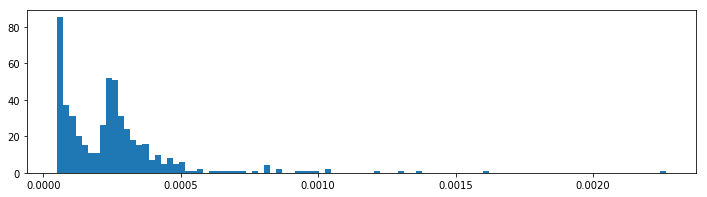

mixed4c
512


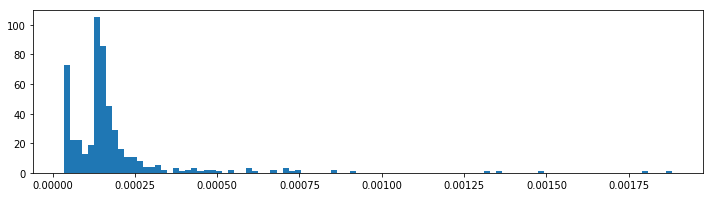

mixed4d
528


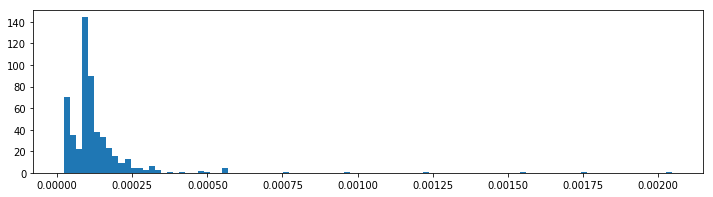

mixed4e
832


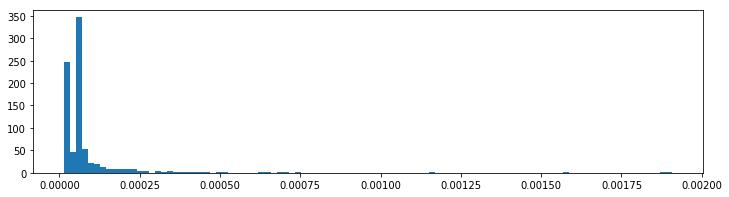

mixed5a
832


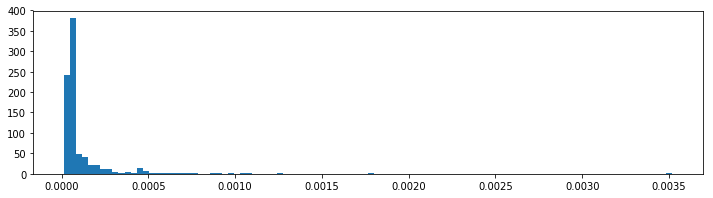

mixed5b
1024


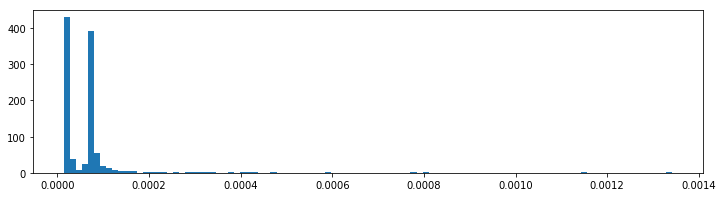

class: 270, time: 30.06 sec
mixed3a
251


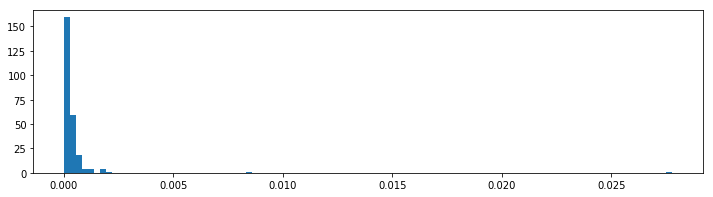

mixed3b
480


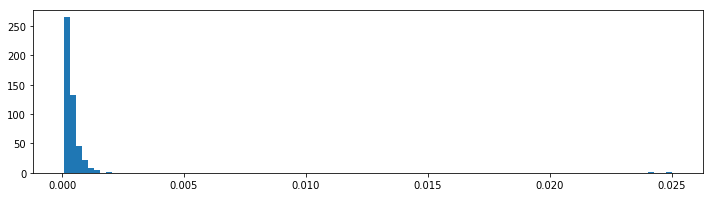

mixed4a
508


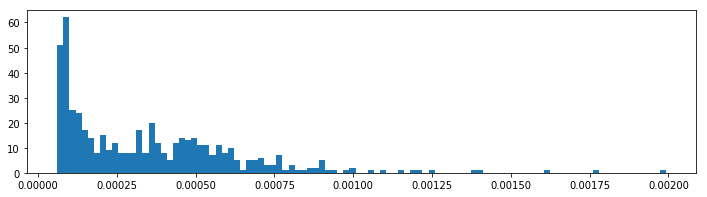

mixed4b
512


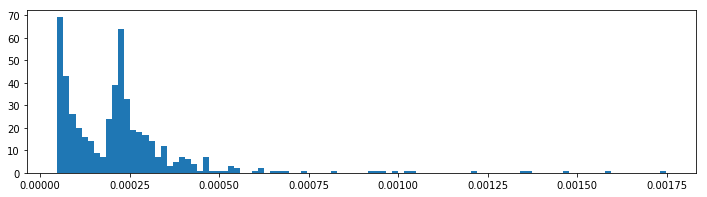

mixed4c
512


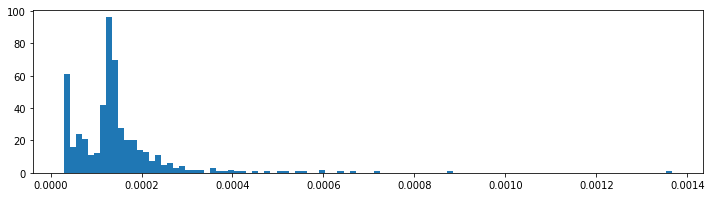

mixed4d
528


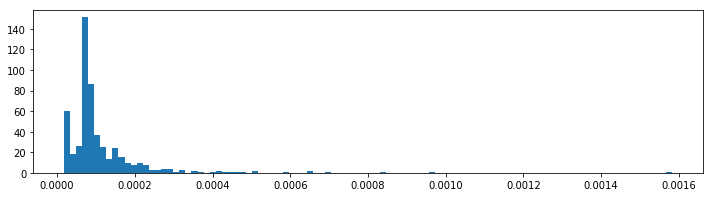

mixed4e
832


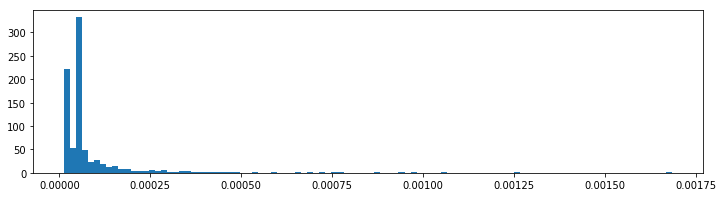

mixed5a
832


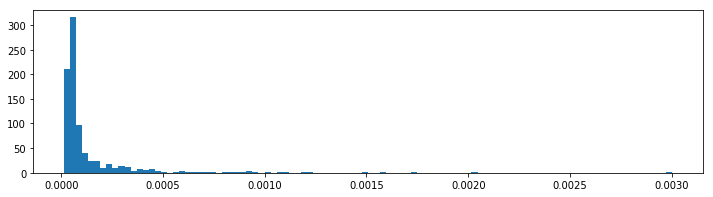

mixed5b
1024


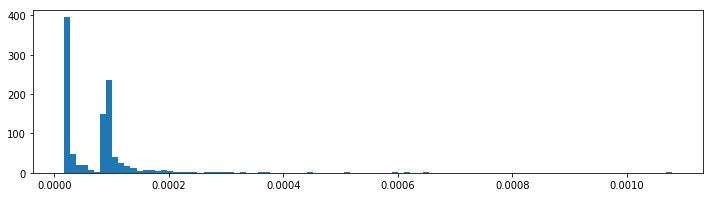

class: 294, time: 31.83 sec
mixed3a
253


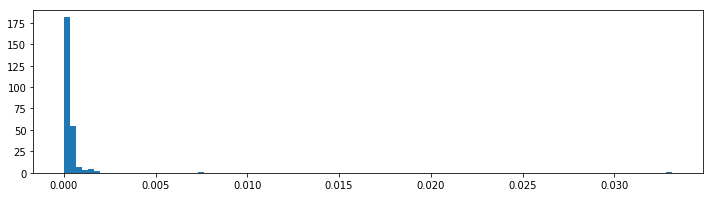

mixed3b
480


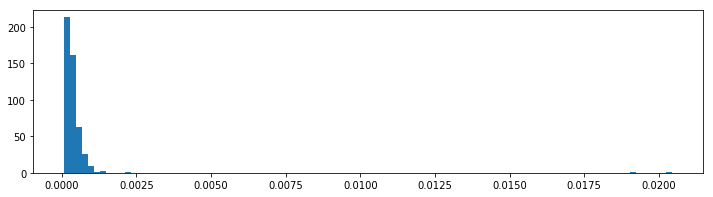

mixed4a
508


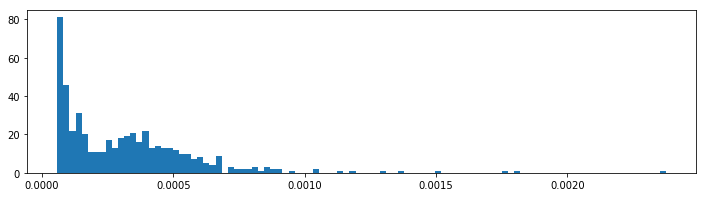

mixed4b
512


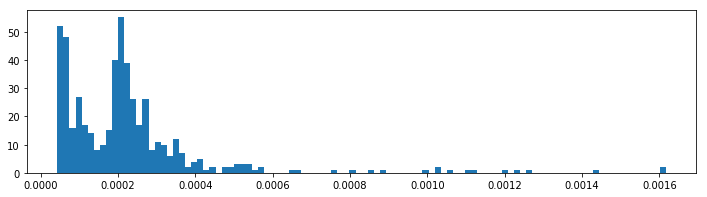

mixed4c
512


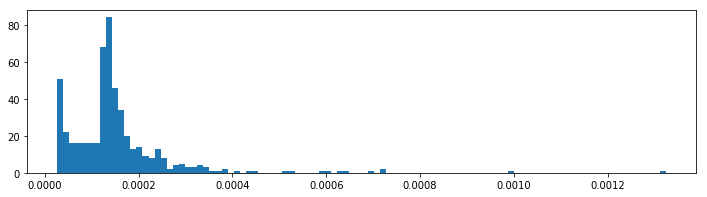

mixed4d
528


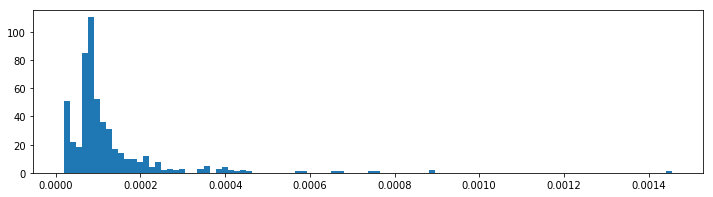

mixed4e
832


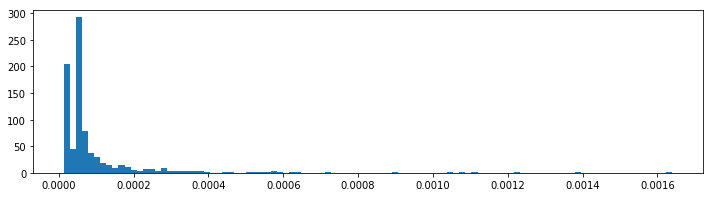

mixed5a
832


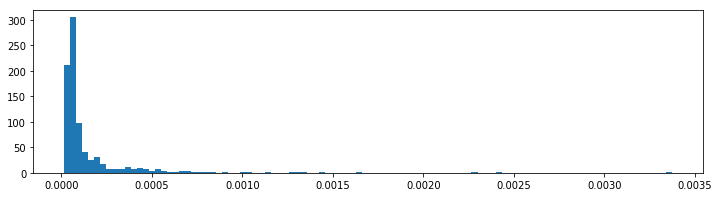

mixed5b
1024


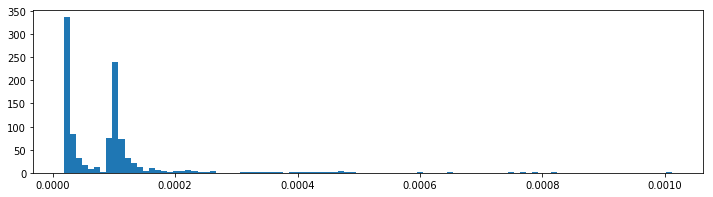

class: 295, time: 33.89 sec
mixed3a
250


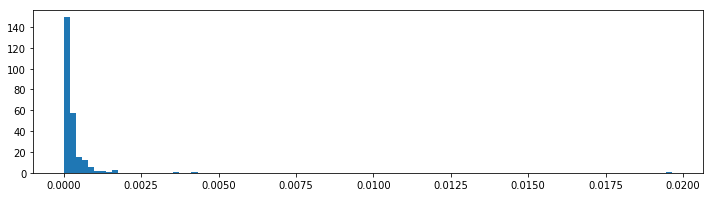

mixed3b
480


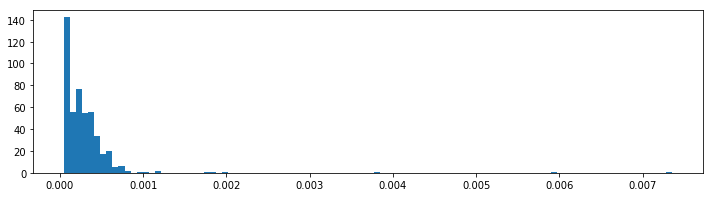

mixed4a
508


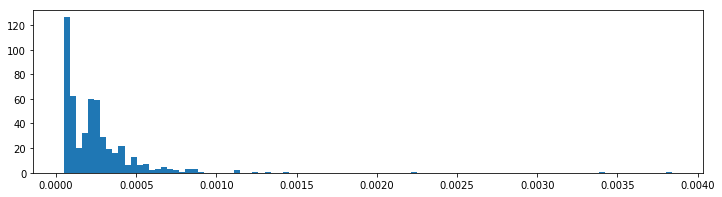

mixed4b
512


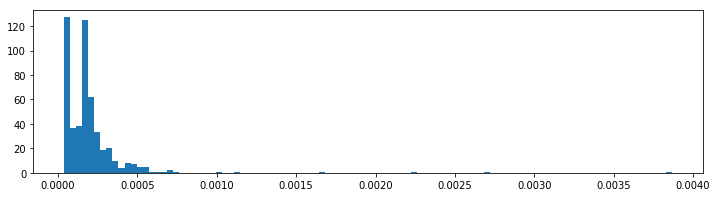

mixed4c
512


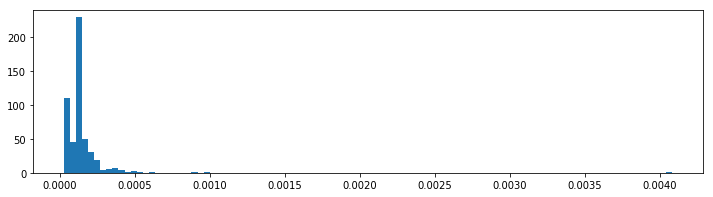

mixed4d
528


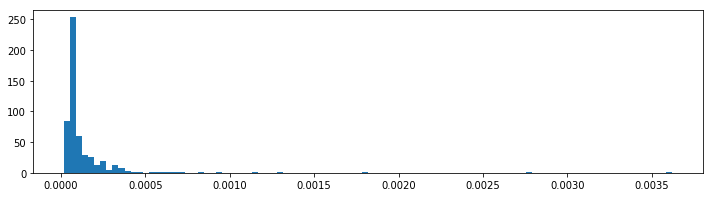

mixed4e
832


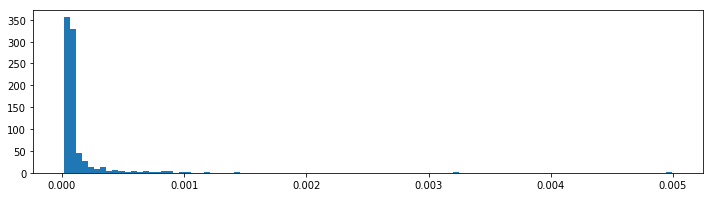

mixed5a
832


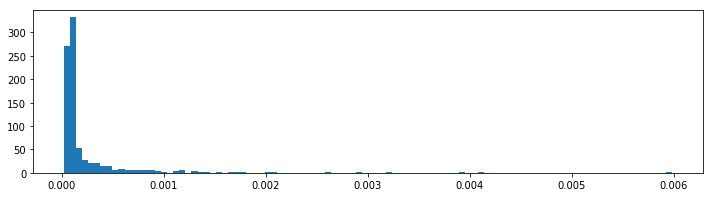

mixed5b
1024


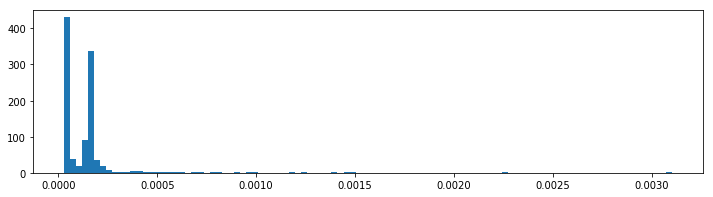

class: 407, time: 26.23 sec


In [46]:
num_class = 1000
prob_mass_dict = {}
unified_threshold=False

# start at 1%, increase by 0.5% if no connecetions/channels in a layer
prob_mass_initial = 0.075
prob_mass_increase = 0.005

for pred_class in range(num_class):
    prob_mass_thresholds = {layer: prob_mass_initial for layer in mixed_layers}

    if pred_class not in [55,270,294,295,407]:
        continue
        
    tic = time()
    
    # Extract influence information for the pred_class
    Is_class = extract_class_I_matrices(Is, all_layers, start_layer, end_layer, pred_class, verbose=False)
    
    # Initialize an undirected graph
    G = nx.Graph()
    
    # Generate full graph
    gen_full_graph(Is_class, G, mixed_layers)
    
    # Read M-matrices
    Ms = read_Ms(M_mat_dirpath, mixed_layers)
    
    # Personalized pagerank to filter nodes
    personalization = get_personalization_dict(G, Ms, mixed_layers, pred_class, outlier_nodes)
    pagerank = nx.pagerank(G, personalization=personalization, weight='weight', alpha=0.85)
    
    ######

    for layer in mixed_layers:
        print(layer)
        
        pagerank_values = []
        for node in pagerank:
            if node.split('-')[0] == layer:
                pagerank_values.append(pagerank[node])
        
        print(len(pagerank_values))
        plt.figure(figsize=(12,3))
        plt.hist(pagerank_values, bins=100)
        plt.show()
    
    
    #######
    
    need_to_relax = True

    while need_to_relax:
        
        # Thresolding
        thresholds = get_threshold(mixed_layers, pagerank, prob_mass_thresholds=prob_mass_thresholds, unified_threshold=unified_threshold)
        thresholded_nodes = get_thresholded_nodes(pagerank, thresholds, outlier_nodes=outlier_nodes)
        thresholded_edges = get_thresholded_edges(mixed_layers, G, thresholded_nodes)

        # Generate dag in json format
        dag, layer_validity = gen_dag(mixed_layers, thresholded_nodes, thresholded_edges, pagerank, Is, pred_class)
        
        need_to_relax = False in layer_validity.values()
        if need_to_relax:
            if unified_threshold:
                for layer in mixed_layers:
                    prob_mass_thresholds[layer] += prob_mass_increase
            else:
                for layer_idx, layer in enumerate(mixed_layers[1:]):
                    if not layer_validity[layer]:
                        prev_layer = mixed_layers[layer_idx]
                        prob_mass_thresholds[prev_layer] += prob_mass_increase
                        prob_mass_thresholds[layer] += prob_mass_increase

    # Save prob_mass_threshold
    prob_mass_dict[pred_class] = prob_mass_thresholds
    
    # Save the graph into a file
    filename = dag_dirpath + 'pagerank/' + 'dag-{}-{}.json'.format(pred_class, 'unified' if unified_threshold else 'separate')
    with open(filename, 'w') as f:
        json.dump(dag, f, indent=2)

    toc = time()

    print('class: %s, time: %.2lf sec' % (pred_class, toc - tic))
#     print(nx.info(G))
    
filename = dag_dirpath + 'pagerank/' + 'prob-mass-threshold-{}.json'.format('unified' if unified_threshold else 'separate')
with open(filename, 'w') as f:
    json.dump(prob_mass_dict, f, indent=2)

In [47]:
thresholds

{'mixed5b': 0.0012446976370930028,
 'mixed5a': 0.0032363149231407627,
 'mixed4e': 0.0014454785321230473,
 'mixed4d': 0.0018081460887750154,
 'mixed4c': 0.0006113541377277726,
 'mixed4b': 0.0016696127655474722,
 'mixed4a': 0.0012457333887808191,
 'mixed3b': 0.0005819272215602346,
 'mixed3a': 0.0017666588319969973}

In [70]:
from collections import defaultdict
pg_dict = defaultdict(lambda: {'min': 100, 'max': -100})
for node in pagerank:
    if node in outlier_nodes:
        continue
    layer, channel = node.split('-')
    val = pagerank[node]
    pg_dict[layer] = {'min': min(pg_dict[layer]['min'], val), 'max': max(pg_dict[layer]['max'], val)}

In [72]:
for layer in pg_dict:
    m, M = pg_dict[layer]['min'], pg_dict[layer]['max']
    print('%s, min:%.4lf, max:%.4lf' % (layer, m, M))

mixed5b, min:0.0000, max:0.0013
mixed5a, min:0.0000, max:0.0035
mixed4e, min:0.0000, max:0.0019
mixed4d, min:0.0000, max:0.0020
mixed4c, min:0.0000, max:0.0019
mixed4b, min:0.0001, max:0.0023
mixed4a, min:0.0001, max:0.0023
mixed3b, min:0.0001, max:0.0024
mixed3a, min:0.0000, max:0.0020
